In [1]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random
import pandas as pd
import seaborn as sns 

Segmentation Models: using `keras` framework.


In [2]:
# importing the tram_csv
tram_df = pd.read_csv('tram_filenames.csv')
tram_df.drop(columns=tram_df.columns[0], axis=1, inplace=True)
tram_jpg = np.array(tram_df.filename_jpg)
tram_jpg

array(['rs02096.jpg', 'rs07844.jpg', 'rs06555.jpg', ..., 'rs08401.jpg',
       'rs06969.jpg', 'rs05051.jpg'], dtype=object)

In [94]:
import matplotlib.image as mpimg

In [112]:
# Setting up the directory for the files 
path_images = 'rs19_val/jpgs/rs19_val/'
path_masks = 'rs19_val/uint8/rs19_val/' 

# Setting up a breaker for test run 
breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    if filename.endswith('.jpg') and filename in tram_jpg:
        image = Image.open(path_images+filename)
        image = np.array(image.resize((64, 64),3))
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        kernel_size = 5 # Must be an odd number (3, 5, 7...)
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
        low_threshold = 180
        high_threshold = 240
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        #plt.imshow(edges, cmap='Greys_r')
        #plt.title("Canny Edge Detection Image")
        #plt.show()
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = np.array(mask.resize((64, 64),3))
        mask = np.expand_dims(mask, axis=2)
        mask = np.zeros_like(edges)   
        ignore_mask_color = 255   
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 2     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 4 #minimum number of pixels making up a line
        max_line_gap = 5    # maximum gap in pixels between connectable line segments
        line_image = np.copy(image)*0 # creating a blank to draw lines on

        # This time we are defining a four sided polygon to mask
        imshape = image.shape
        vertices = np.array([[(0,imshape[0]),(870, 550), (970, 550), (imshape[1],imshape[0])]], dtype=np.int32)
        mask = np.zeros_like(edges)
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_edges = cv2.bitwise_and(edges, mask)
        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
        # Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

        # Create a "color" binary image to combine with line image
        color_edges = np.dstack((edges, edges, edges)) 

        # Draw the lines on the edge image
        lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
        lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
        plt.imshow(image)
        plt.title("Input Image")
        plt.show()
        plt.imshow(lines_edges)
        plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
        plt.show()
        for layer in range(len(mask[0,0,:])):
            #mask[:int(256/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==5:
        break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

TypeError: 'NoneType' object is not iterable

In [80]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


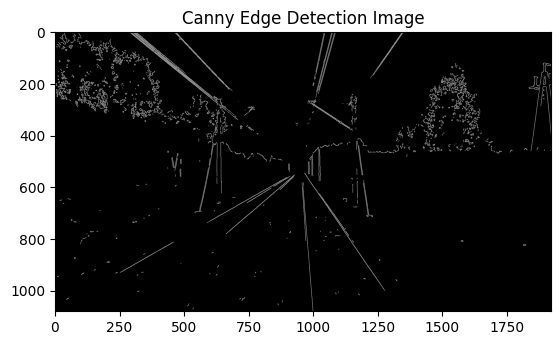

In [93]:
# Do all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
image = mpimg.imread("rs19_val/jpgs/rs19_val/rs00267.jpg")
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

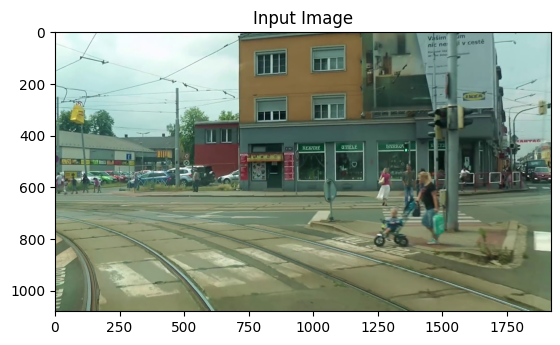

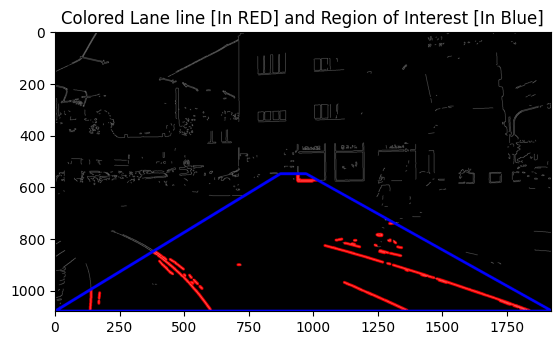

In [90]:
image = mpimg.imread("rs19_val/jpgs/rs19_val/rs00497.jpg")
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(870, 550), (970, 550), (imshape[1],imshape[0])]], dtype=np.int32)
mask = np.zeros_like(edges)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

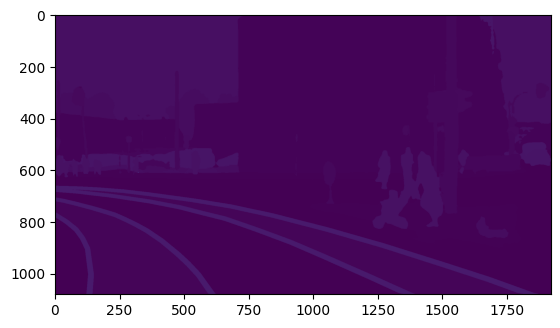

In [91]:
img_mask = mpimg.imread("rs19_val/uint8/rs19_val/rs00497.png")
label_of_interest = 8 #veg
# VEG-FOCUSED mask
#img_mask[img_mask!=label_of_interest]=0
#img_mask[img_mask==label_of_interest]=1
#img_mask[img_mask!=0]=8
plt.imshow(img_mask)

In [48]:
"""
Step 3 & 4 explanation:
If pixel_value = veg and depth_value != 0 then:
    pixel_value = veg
Else:
    pixel_value = 0
"""
label_of_interest = 8 #veg

dataset_mask_multiplied = img_mask * mask


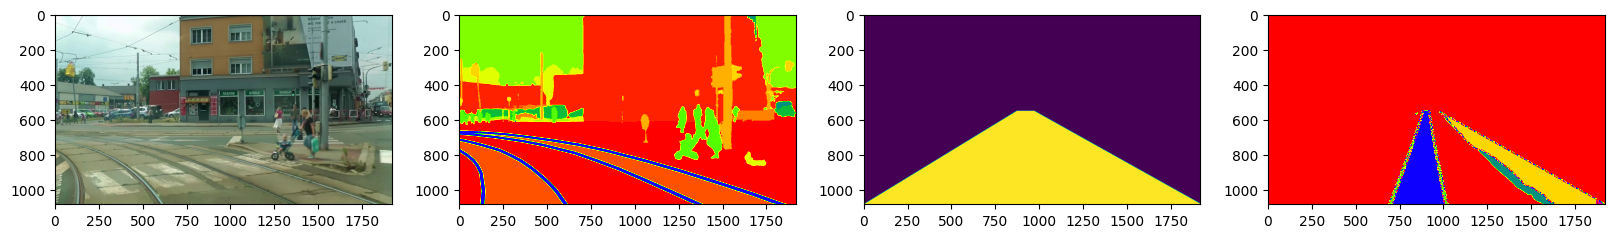

In [92]:
index = 22
f, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
axis_arr[0].imshow(image)
axis_arr[1].imshow(img_mask, cmap='prism')
axis_arr[2].imshow(mask)
axis_arr[3].imshow(dataset_mask_multiplied, cmap='prism')

------------------------